In [1]:
import sys
from pathlib import Path
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
plt.style.use('Solarize_Light2')

sys.path.append(str(Path("../../..").resolve()))
from src.constants import model_data_dir

In [3]:
remove_cols = ["sc_1d_fwd_rel_ret", "mom_1d_fwd_rel_ret"]

df_train = pd.read_csv(model_data_dir / "train_regression.csv").drop(remove_cols + ["date"], axis=1)
df_test = pd.read_csv(model_data_dir / "test_regression.csv").drop(remove_cols, axis=1)
test_dates = pd.to_datetime(df_test["date"])
df_test = df_test.drop("date", axis=1)

In [4]:
df_all = pd.concat([df_train, df_test], axis=0)

/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


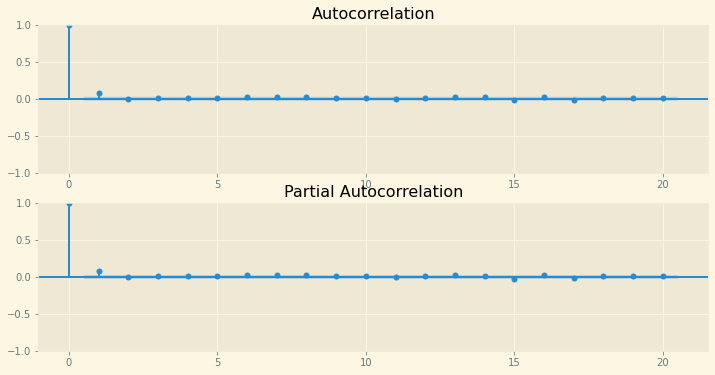

In [5]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df_all["value_1d_fwd_rel_ret"], ax=ax[0], lags=20)
ax[1] = plot_pacf(df_all["value_1d_fwd_rel_ret"], ax=ax[1], lags=20)

In [6]:
ets_fit = ExponentialSmoothing(
    df_train["value_1d_fwd_rel_ret"],
    seasonal_periods=4,
    trend="add",
    seasonal="add",
    damped_trend=True,
    initialization_method="estimated",
).fit()

In [7]:
preds = ets_fit.forecast(df_test.shape[0]).reset_index(drop=True)
y_test = df_test["value_1d_fwd_rel_ret"].reset_index(drop=True)
np.mean(np.abs(preds - y_test))

0.0028201540974181916

<AxesSubplot:xlabel='ds', ylabel='price'>

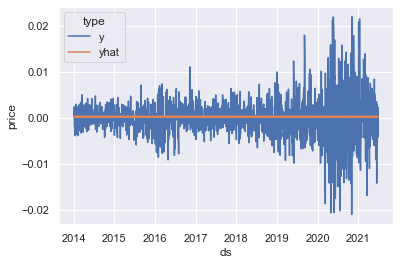

In [8]:
import seaborn as sns
sns.set_theme(style="darkgrid")

df_preds = pd.DataFrame({"ds": test_dates, "y": y_test, "yhat": preds})
plot_data = df_preds.melt(id_vars="ds", var_name="type", value_name="price")

# Plot the responses for different events and regions
sns.lineplot(x="ds", y="price",
             hue="type",
             data=plot_data)